# Titulo epico
**Autor:** Miguel Angel  
**Fecha:** Septiembre 2025  

Este notebook analiza cosas epicas

## 1. Introducción
Explicación del problema...

## 2. Importación de librerías

In [87]:
import pandas as pd
import pyodbc as db
import matplotlib.pyplot as plt

## 3. Analisis de integridad de los datos

#### Melt de tabla sales_train_validation para que cada columna d_ pase a ser una sola columna d

In [ ]:
sales_original = pd.read_csv("sales_train_validation.csv")
## Convertir columnas [d_1,d_1913] a registros de una columna d
## Para esto utilizamos un melt
id_columns = ["item_id", "dept_id", "cat_id", "store_id"]
value_columns = [c for c in sales_original.columns if c.startswith("d_")]

sales_formatted = sales_original.melt(
    id_vars = id_columns,
    value_vars = value_columns,
    var_name = "d",   
    value_name = "sales"
)

## Exportamos sales_formatted a csv
sales_formatted.to_csv("sales_formatted.csv", index=False)
## Execution time: 1m 27s

El dataset *calendar* trae dos columnas para eventos porque en un mismo día pueden ocurrir hasta dos distintos (ej. un festivo y un evento deportivo). Para compatibilidad se mantendra así.

“En el dataset calendar noté que los eventos están duplicados en dos columnas (event_name_1/2 y event_type_1/2) porque algunos días pueden tener hasta dos eventos distintos.
Para mis consultas principales mantuve la tabla original, ya que la gran mayoría de días tiene como mucho un evento, y por tiempos enfoqué el análisis en la parte de ventas y revenue.
Sin embargo, como mejora futura propondría normalizar estas columnas en una tabla calendar_events, con una fila por evento, lo que haría más simple y escalable analizar múltiples eventos en un mismo día.”

#### Se importan archivos csv

In [50]:
calendar = pd.read_csv("calendar.csv")
sales_formatted = pd.read_csv("sales_formatted.csv")
sell_prices = pd.read_csv("sell_prices.csv")

In [ ]:
# Analizar estructura general
calendar.info()
sales_formatted.info()
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [ ]:
# Se revisan valores nulos
calendar.isnull().sum() # -> Only nulls in events
sales_formatted.isnull().sum() # -> Not nulls
sell_prices.isnull().sum() # -> Not nulls

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

In [ ]:
# Se revisan datos duplicados
calendar.duplicated().sum() # -> No hay duplicados
sales_formatted.duplicated().sum() # -> No hay duplicados
sell_prices.duplicated().sum() # -> No hay duplicados

np.int64(0)

In [ ]:
# Validar claves y relaciones
sales_formatted.set_index(["store_id", "item_id", "d"]).index.is_unique # -> No hay duplicados que violen la integridad
sell_prices.set_index(["store_id", "item_id", "wm_yr_wk"]).index.is_unique # -> No hay duplicados que violen la integridad

True

In [ ]:
# Rangos y valores logicos
(sales_formatted["sales"] < 0).sum() # -> No hay ventas negativas
(sell_prices["sell_price"] < 0).sum() # -> No hay precios negativos

In [ ]:
# Validacion de fechas
calendar["date"].min(), calendar["date"].max() # ('2011-01-29', '2016-06-19')
len(calendar) # -> 1969 dias consecutivos
calendar.groupby("wm_yr_wk")["d"].count().value_counts().head() # -> 281 semanas comerciales de 7 dias y 1 semana
#                                                                    comercial de 2 dias (la primera


d
7    281
2      1
Name: count, dtype: int64

## 4. Conexion con la BD

In [88]:
connection = db.connect("DRIVER={ODBC Driver 17 for SQL Server};SERVER=MIGUESGO;DATABASE=M5_Forcasting;Trusted_Connection=yes;")

## 5. Analisis

In [ ]:
# Número de articulos vendidas en todo el periodo
query = """
    SELECT SUM(sales) AS unidades_vendidas
    FROM dbo.sales_formatted;
"""

unidades_vendidas = pd.read_sql(query, connection)
unidades_vendidas # 65,695,409 units

C:\Users\migue\AppData\Local\Temp\ipykernel_18392\1096779049.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ventas_totales = pd.read_sql(query, connection)


,total_sales_overall
0,65695409


In [ ]:
# Venta total en todo el periodo
query = """
    SELECT SUM(S.sales * SP.sell_price) AS total_revenue
    FROM dbo.sales_formatted AS S
    JOIN dbo.calendar AS C ON S.d = C.d
    JOIN dbo.sell_prices AS SP
        ON SP.item_id = S.item_id
        AND SP.store_id = S.store_id
        AND SP.wm_yr_wk = C.wm_yr_wk;
"""

total_revenue = pd.read_sql(query, connection)
float(total_revenue["total_revenue"]) # -> $ 187,676,570.01990828

C:\Users\migue\AppData\Local\Temp\ipykernel_18392\2243354402.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_revenue = pd.read_sql(query, connection)


,total_revenue
0,1.876766e+08


C:\Users\migue\AppData\Local\Temp\ipykernel_18392\453487777.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_sales_by_year = pd.read_sql(query, connection)


   year  total_sales_by_year
0  2011                 8.86
1  2012                12.06
2  2013                13.14
3  2014                13.09
4  2015                13.80
5  2016                 4.75


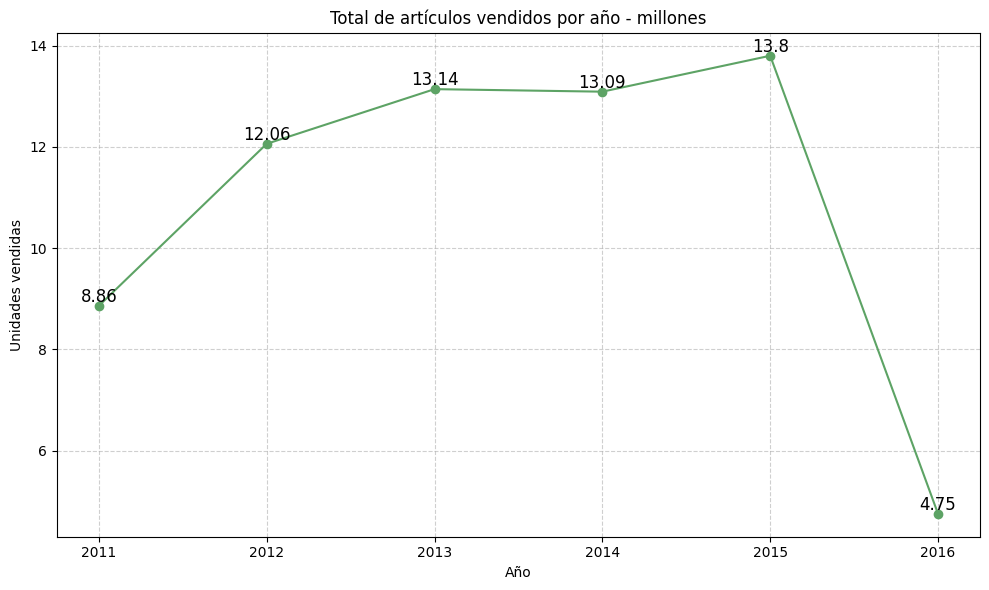

In [69]:
# Articulos vendidos por año - en millones
query = """
    SELECT C.year,
	   SUM(S.sales) AS total_sales_by_year
    FROM dbo.sales_formatted AS S
    JOIN dbo.calendar AS C ON C.d = S.d
    GROUP BY C.year
    ORDER BY C.year
"""
total_sales_by_year = pd.read_sql(query, connection)
total_sales_by_year["total_sales_by_year"] = (
    round(total_sales_by_year["total_sales_by_year"] / 1000000, 2)
)
print(total_sales_by_year)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(total_sales_by_year["year"],
        total_sales_by_year["total_sales_by_year"],
        marker="o",
        linestyle="-",
        color="#5DA365")
for x, y in zip(total_sales_by_year["year"], total_sales_by_year["total_sales_by_year"]):
    ax.text(x, y, f"{y:,}", ha="center", va="bottom", fontsize=12)
ax.set_title("Total de artículos vendidos por año - millones")
ax.set_xlabel("Año")
ax.set_ylabel("Unidades vendidas")
ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


C:\Users\migue\AppData\Local\Temp\ipykernel_18392\2935201129.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_revenue = pd.read_sql(query, connection)


   year  total_revenue
0  2011          23.89
1  2012          32.65
2  2013          35.92
3  2014          37.86
4  2015          42.42
5  2016          14.93


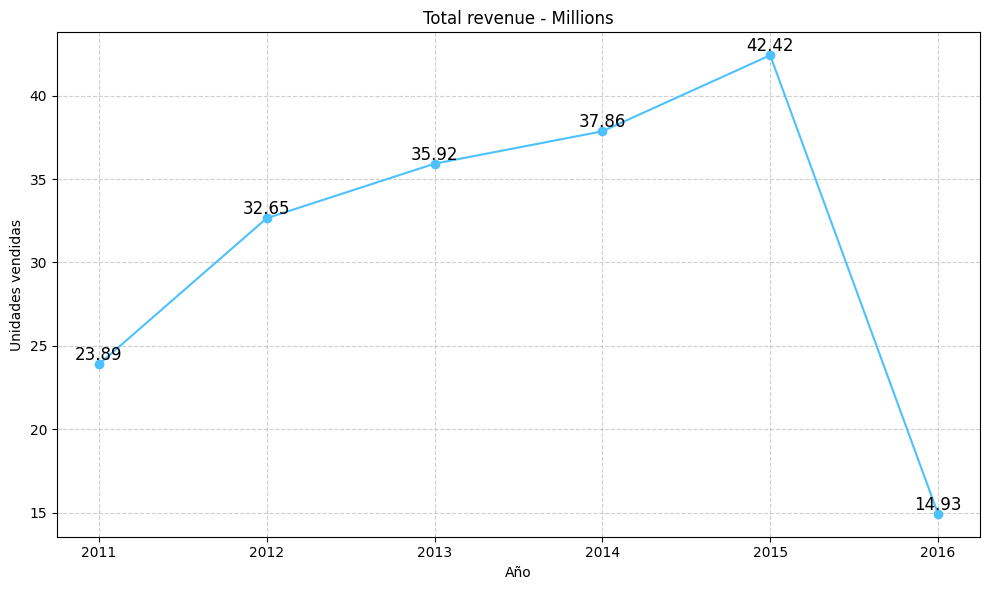

In [ ]:
# Venta por año - en millones
query = """
    SELECT C.year,
        SUM(S.sales * SP.sell_price) AS total_revenue
    FROM dbo.sales_formatted AS S
    JOIN dbo.calendar AS C ON C.d = S.d
    JOIN dbo.sell_prices AS SP
        ON SP.store_id = S.store_id
        AND SP.item_id = S.item_id
        AND SP.wm_yr_wk = C.wm_yr_wk
    GROUP BY C.year;
"""
total_revenue = pd.read_sql(query, connection)
total_revenue["total_revenue"] = (
    round(total_revenue["total_revenue"] / 1000000, 2)
)
print(total_revenue)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(total_revenue["year"],
        total_revenue["total_revenue"],
        marker="o",
        linestyle="-",
        color="#59C5FF")
for x, y in zip(total_revenue["year"], total_revenue["total_revenue"]):
    ax.text(x, y, f"{y:,}", ha="center", va="bottom", fontsize=12)
ax.set_title("Total revenue - Millions")
ax.set_xlabel("Año")
ax.set_ylabel("Unidades vendidas")
ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

C:\Users\migue\AppData\Local\Temp\ipykernel_18392\3650370529.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_sales_from_item = pd.read_sql(query, connection)


           store_item  max_sales
0  CA_1 - FOODS_3_090     127203
1  CA_2 - FOODS_3_586      63416
2  CA_3 - FOODS_3_090     250502
3  CA_4 - FOODS_3_090      52264
4  TX_1 - FOODS_3_586     112454
5  TX_2 - FOODS_3_586     192835
6  TX_3 - FOODS_3_586     150122
7  WI_1 - FOODS_3_226      78993
8  WI_2 - FOODS_3_226      69966
9  WI_3 - FOODS_3_090     121434


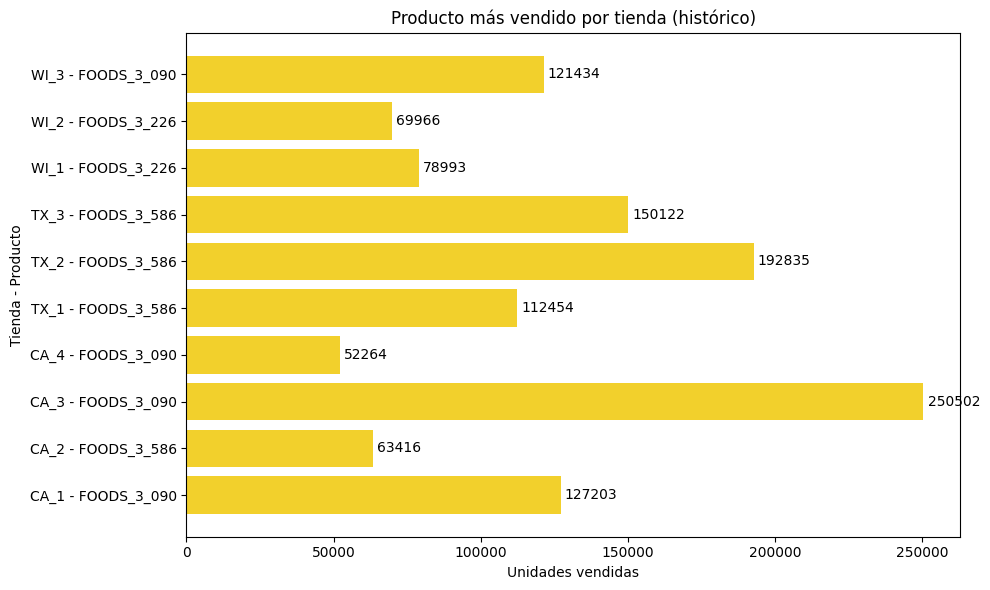

In [ ]:
# -- Product that sold more units per store
query = """
    WITH total_sales_from_item AS (
        -- Total sales from every item in all stores
        SELECT store_id,
            item_id,
            SUM(sales) AS total_sales
        FROM dbo.sales_formatted
        GROUP BY store_id, item_id
    ), max_sales_from_store AS (
        -- Max sales from every store
        SELECT store_id,
        MAX(total_sales) as max_sales
        FROM total_sales_from_item
        GROUP BY store_id
    )
    SELECT TS.store_id,
        TS.item_id,
        MS.max_sales
    FROM total_sales_from_item AS TS
    JOIN max_sales_from_store AS MS
        ON TS.store_id = MS.store_id
        AND TS.total_sales = MS.max_sales
    ORDER BY store_id;
"""
total_sales_from_item = pd.read_sql(query, connection)
total_sales_from_item["store_item"] = (
    total_sales_from_item["store_id"] + " - " + total_sales_from_item["item_id"] 
)
print(total_sales_from_item[["store_item", "max_sales"]])

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(total_sales_from_item["store_item"],
               total_sales_from_item["max_sales"],
               color="#5DA365")
ax.bar_label(bars, padding=3, fmt="%.0f")
ax.set_title("Producto más vendido por tienda (histórico)")
ax.set_xlabel("Unidades vendidas")
ax.set_ylabel("Tienda - Producto")

plt.tight_layout()
plt.show()



C:\Users\migue\AppData\Local\Temp\ipykernel_18392\615766599.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_sales_by_product = pd.read_sql(query, connection)


                       dept_item  max_sales
0          FOODS_1 - FOODS_1_218     234594
1          FOODS_2 - FOODS_2_360     257119
2          FOODS_3 - FOODS_3_090    1002529
3      HOBBIES_1 - HOBBIES_1_371     122565
4      HOBBIES_2 - HOBBIES_2_142      24611
5  HOUSEHOLD_1 - HOUSEHOLD_1_334     171275
6  HOUSEHOLD_2 - HOUSEHOLD_2_176      36283


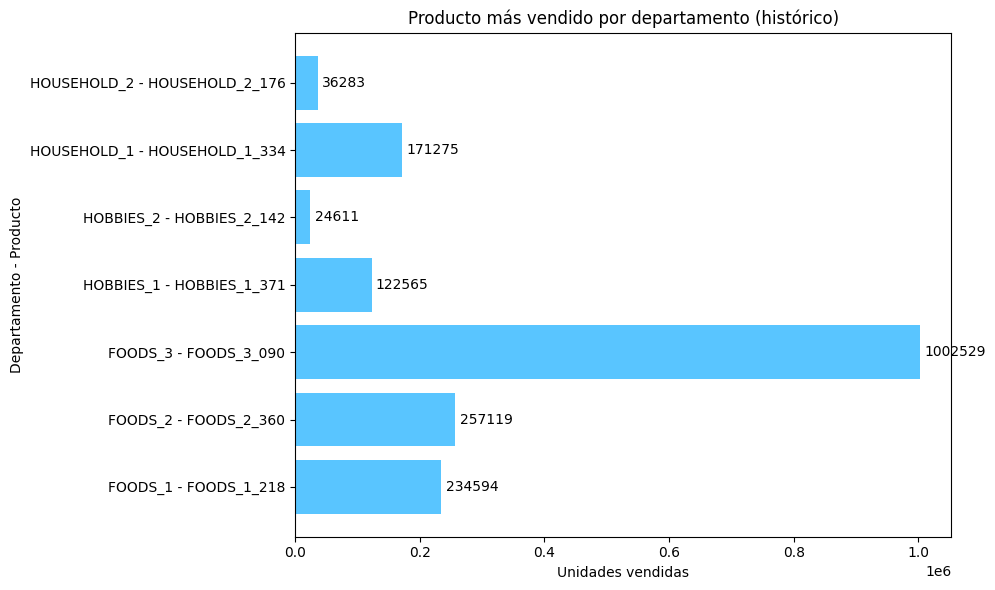

In [76]:
# -- Product that sold more items per department
query = """
    WITH total_sales_by_product AS (
        -- total sales by product overall
        SELECT dept_id,
            item_id,
            SUM(sales) AS total_sales
        FROM dbo.sales_formatted
        GROUP BY dept_id, item_id
    ), max_sales AS (
        SELECT dept_id,
            MAX(total_sales) AS max_sales
        FROM total_sales_by_product
        GROUP BY dept_id
    )
    SELECT TS.dept_id,
        TS.item_id,
        MS.max_sales
    FROM total_sales_by_product AS TS
    JOIN max_sales AS MS
        ON TS.dept_id = MS.dept_id
        AND TS.total_sales = MS.max_sales
    ORDER BY dept_id;
"""

total_sales_by_product = pd.read_sql(query, connection)
total_sales_by_product["dept_item"] = (
    total_sales_by_product["dept_id"] + " - " + total_sales_by_product["item_id"]
)
print(total_sales_by_product[["dept_item", "max_sales"]])

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(total_sales_by_product["dept_item"],
               total_sales_by_product["max_sales"],
               color="#59C5FF")
ax.bar_label(bars, padding=3, fmt="%.0f")
ax.set_title("Producto más vendido por departamento (histórico)")
ax.set_xlabel("Unidades vendidas")
ax.set_ylabel("Departamento - Producto")

plt.tight_layout()
plt.show()


C:\Users\migue\AppData\Local\Temp\ipykernel_18392\1208413575.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_sales_by_product = pd.read_sql(query, connection)


                      cat_item  max_sales
0          FOODS - FOODS_3_090    1002529
1      HOBBIES - HOBBIES_1_371     122565
2  HOUSEHOLD - HOUSEHOLD_1_334     171275


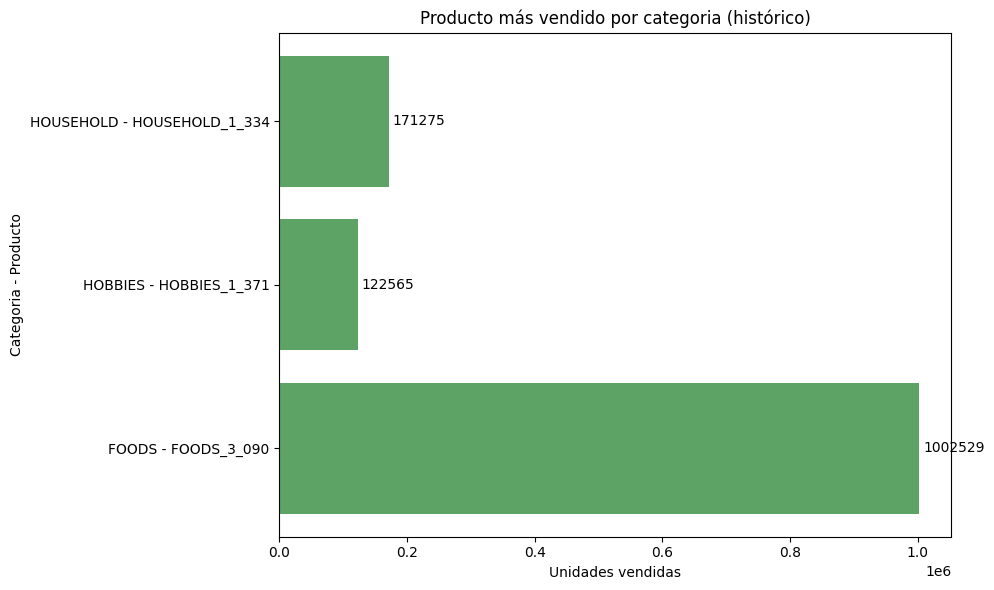

In [77]:
# -- Product that sold more units per category
query = """
    WITH total_sales_by_product AS (
        -- total sales by product overall
        SELECT cat_id,
            item_id,
            SUM(sales) AS total_sales
        FROM dbo.sales_formatted
        GROUP BY cat_id, item_id
    ), max_sales AS (
        SELECT cat_id,
            MAX(total_sales) AS max_sales
        FROM total_sales_by_product
        GROUP BY cat_id
    )
    SELECT TS.cat_id,
        TS.item_id,
        MS.max_sales
    FROM total_sales_by_product AS TS
    JOIN max_sales AS MS
        ON TS.cat_id = MS.cat_id
        AND TS.total_sales = MS.max_sales
    ORDER BY cat_id;
"""

total_sales_by_product = pd.read_sql(query, connection)
total_sales_by_product["cat_item"] = (
    total_sales_by_product["cat_id"] + " - " + total_sales_by_product["item_id"]
)
print(total_sales_by_product[["cat_item", "max_sales"]])

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(total_sales_by_product["cat_item"],
               total_sales_by_product["max_sales"],
               color="#5DA365")
ax.bar_label(bars, padding=3, fmt="%.0f")
ax.set_title("Producto más vendido por categoria (histórico)")
ax.set_xlabel("Unidades vendidas")
ax.set_ylabel("Categoria - Producto")

plt.tight_layout()
plt.show()


C:\Users\migue\AppData\Local\Temp\ipykernel_18392\631682253.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  top_three_products = pd.read_sql(query, connection)


  store_id      item_id  total_sales
0     CA_1  FOODS_3_090       127203
1     CA_1  FOODS_3_586        87691
2     CA_1  FOODS_3_252        74971
3     CA_2  FOODS_3_586        63416
4     CA_2  FOODS_3_252        57328


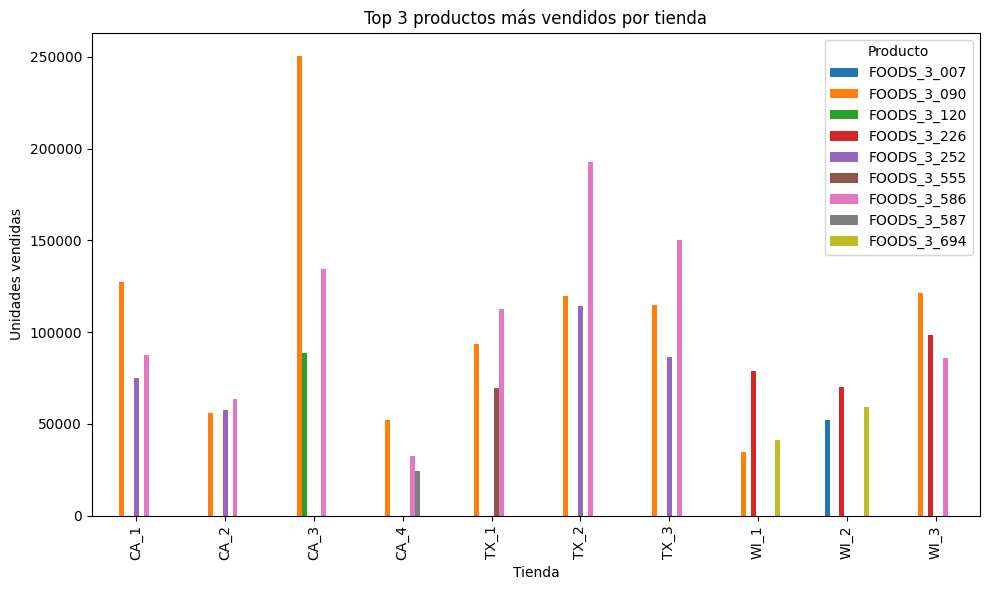

In [79]:
query = """
    -- TOP 3 products that sold more units by store
    WITH top_three_products AS (
        SELECT store_id,
            item_id,
            SUM(sales) AS total_sales,
            ROW_NUMBER() OVER (
                    PARTITION BY store_id
                    ORDER BY SUM(sales) DESC
            ) AS rn
        FROM dbo.sales_formatted
        GROUP BY store_id, item_id
    )
    SELECT store_id,
        item_id,
        total_sales
    FROM top_three_products
    WHERE rn <= 3
    ORDER BY store_id, rn
"""

top_three_products = pd.read_sql(query, connection)
print(top_three_products.head())

fig, ax = plt.subplots(figsize=(10, 6))
pivot = top_three_products.pivot(index="store_id",
                                 columns="item_id",
                                 values="total_sales")
pivot.plot(kind="bar", ax=ax)

ax.set_title("Top 3 productos más vendidos por tienda")
ax.set_xlabel("Tienda")
ax.set_ylabel("Unidades vendidas")
ax.legend(title="Producto")
plt.tight_layout()
plt.show()

C:\Users\migue\AppData\Local\Temp\ipykernel_18392\1707228710.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  revenue = pd.read_sql(query, connection)


  store_id     cat_id      revenue
0     CA_1      FOODS  13380549.24
1     CA_1    HOBBIES   3158380.74
2     CA_1  HOUSEHOLD   5981322.40
3     CA_2      FOODS   8552002.10
4     CA_2    HOBBIES   2162823.27


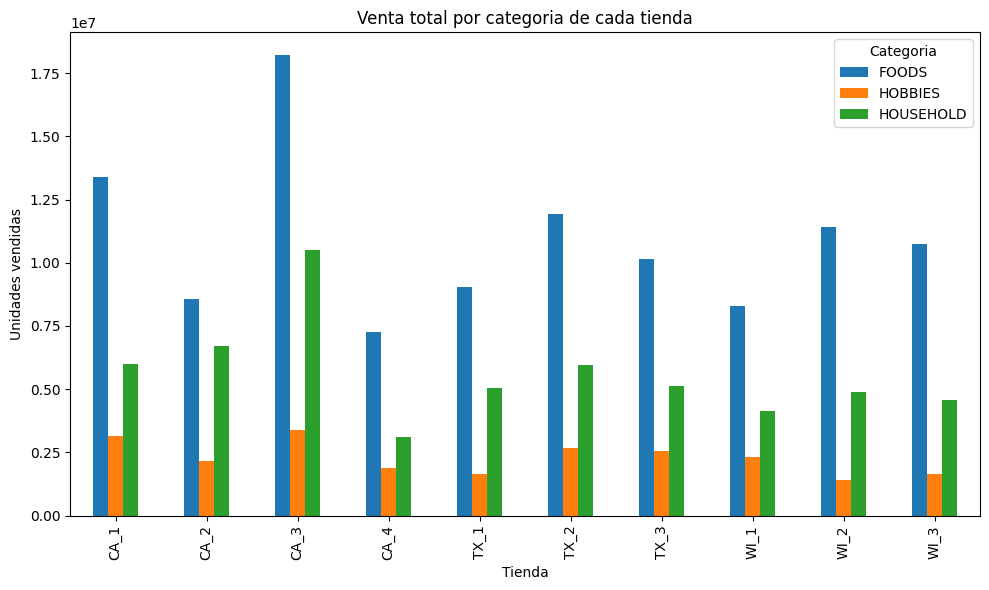

In [95]:
query = """
    -- Total revenue by store and category
    SELECT S.store_id,
        S.cat_id,
        SUM(S.sales * SP.sell_price) AS revenue
    FROM dbo.sales_formatted AS S
    JOIN dbo.calendar AS C ON C.d = S.d
    JOIN dbo.sell_prices AS SP
        ON SP.item_id = S.item_id
        AND SP.store_id = S.store_id
        AND SP.wm_yr_wk = C.wm_yr_wk
    GROUP BY S.store_id, S.cat_id
    ORDER BY S.store_id, cat_id, revenue
"""
revenue = pd.read_sql(query, connection)
print(revenue.head())

fig, ax = plt.subplots(figsize=(10, 6))
pivot = revenue.pivot(index="store_id",
                      columns="cat_id",
                      values="revenue")
pivot.plot(kind="bar", ax=ax)

ax.set_title("Venta total por categoria de cada tienda")
ax.set_xlabel("Tienda")
ax.set_ylabel("Unidades vendidas")
ax.legend(title="Categoria")
plt.tight_layout()
plt.show()


C:\Users\migue\AppData\Local\Temp\ipykernel_18392\1835899449.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  weekday = pd.read_sql(query, connection)


     weekday  sum_units
0  Wednesday       8.19
1   Thursday       8.25
2    Tuesday       8.29
3     Monday       8.97
4     Friday       9.34
5     Sunday      11.27
6   Saturday      11.38


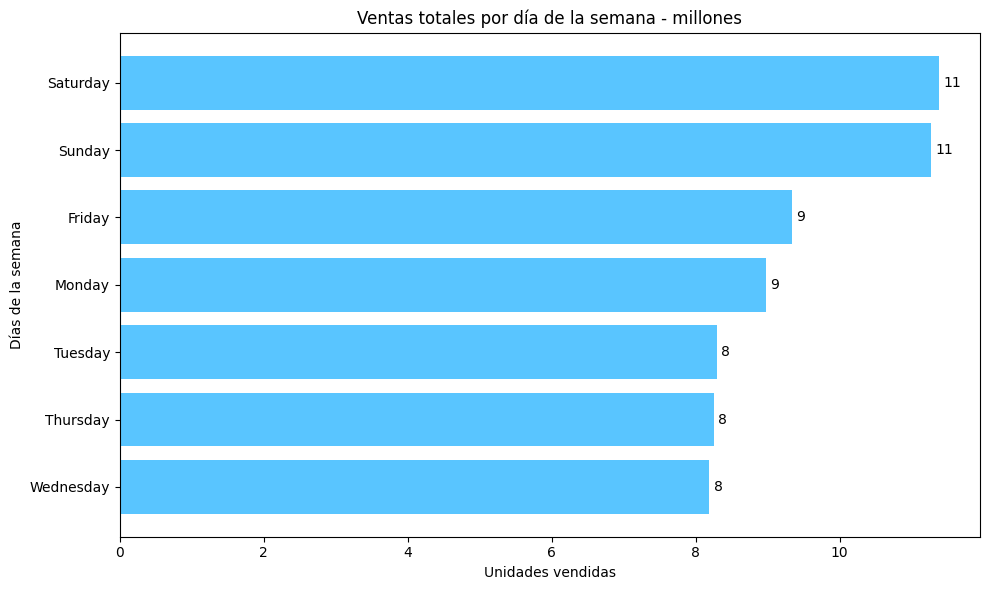

In [ ]:
# -- Sales per weekday
query = """
    SELECT C.weekday,
	   SUM(S.sales) AS sum_units
    FROM dbo.sales_formatted AS S
    JOIN dbo.calendar AS C ON C.d = S.d
    GROUP BY C.weekday
    ORDER BY sum_units
"""

weekday = pd.read_sql(query, connection)
weekday["sum_units"] = (
    round(weekday["sum_units"] / 1000000, 2)
)
print(weekday)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(weekday["weekday"],
               weekday["sum_units"],
               color="#59C5FF")
ax.bar_label(bars, padding=3, fmt="%.0f")
ax.set_title("Ventas totales por día de la semana - millones")
ax.set_xlabel("Unidades vendidas - millones")
ax.set_ylabel("Días de la semana")

plt.tight_layout()
plt.show()

C:\Users\migue\AppData\Local\Temp\ipykernel_18392\1543631000.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  event_sales = pd.read_sql(query, connection)


      event_name  total_units
1      SuperBowl       245544
2      Purim End       215742
3       LaborDay       210773
4  PresidentsDay       206678
5  ValentinesDay       200974


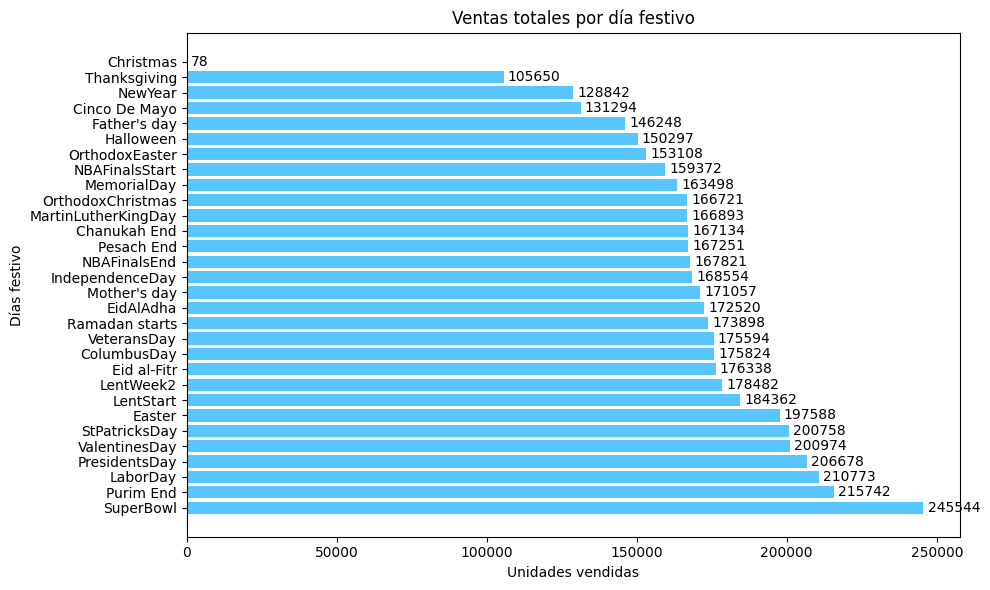

In [92]:
# -- Week with fewer sales and week with more sales
"""
    “Para simplificar el análisis de eventos, usé la función COALESCE,
    que devuelve el primer valor no nulo. Así pude consolidar event_name_1 y event_name_2
    en una sola columna event_name, sin necesidad de reestructurar la tabla calendario.”
"""

query = """
    SELECT 
        COALESCE(C.event_name_1, C.event_name_2) AS event_name,
        SUM(S.sales) AS total_units
    FROM dbo.sales_formatted S
    JOIN dbo.calendar C ON C.d = S.d
    WHERE C.event_name_1 IS NOT NULL OR C.event_name_2 IS NOT NULL
    GROUP BY COALESCE(C.event_name_1, C.event_name_2)
    ORDER BY total_units DESC;
"""

event_sales = pd.read_sql(query, connection)
event_sales = event_sales[1:]
print(event_sales.head())

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(event_sales["event_name"],
               event_sales["total_units"],
               color="#59C5FF")
ax.bar_label(bars, padding=3, fmt="%.0f")
ax.set_title("Ventas totales por día festivo")
ax.set_xlabel("Unidades vendidas")
ax.set_ylabel("Días festivo")

plt.tight_layout()
plt.show()



C:\Users\migue\AppData\Local\Temp\ipykernel_18392\3439015118.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_percentages = pd.read_sql(query, connection)


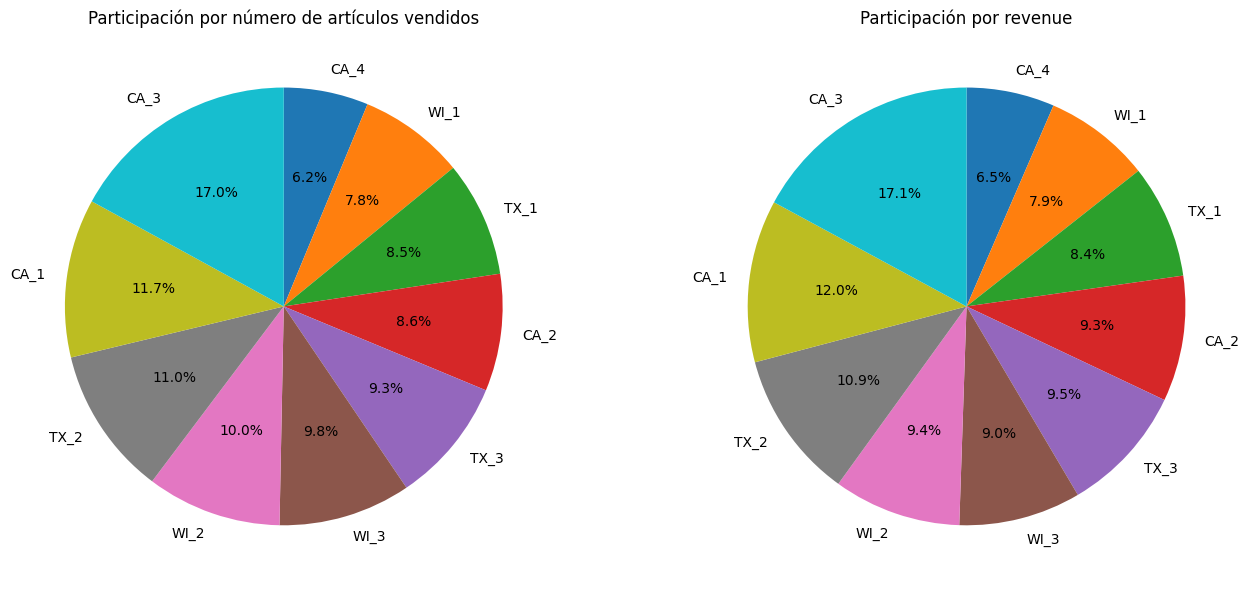

In [94]:
# -- Percentage of revenue and sales from every store
query = """
    WITH quantity_sales_per_store AS (
        SELECT S.store_id,
            SUM(S.sales) AS total_sales_per_store,
            SUM(S.sales * SP.sell_price) AS total_profit_per_store
        FROM dbo.sales_formatted AS S
        JOIN dbo.calendar AS C ON C.d = S.d
        JOIN dbo.sell_prices AS SP
            ON SP.item_id = S.item_id
            AND SP.store_id = S.store_id
            AND SP.wm_yr_wk = C.wm_yr_wk
        GROUP BY S.store_id
    ), quantity_sales_overall AS (
        SELECT SUM(S.sales) AS total_sales_overall,
            SUM(S.sales * SP.sell_price) AS total_profit_overall
        FROM dbo.sales_formatted AS S
        JOIN dbo.calendar AS C ON C.d = S.d
        JOIN dbo.sell_prices AS SP
            ON SP.item_id = S.item_id
            AND SP.store_id = S.store_id
            AND SP.wm_yr_wk = C.wm_yr_wk
    )
    SELECT QSS.store_id,
        ROUND(100.0 * QSS.total_sales_per_store / QSO.total_sales_overall, 2) AS total_sales_percentage,
        ROUND(100.0 * QSS.total_profit_per_store / QSO.total_profit_overall, 2) AS total_profit_percentage
    FROM quantity_sales_per_store AS QSS
    CROSS JOIN quantity_sales_overall AS QSO
    ORDER BY total_sales_percentage, total_profit_percentage;
"""

total_percentages = pd.read_sql(query, connection)
total_percentages

# Crear dos gráficos de pastel lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Primer pastel: porcentaje de ventas en unidades
axes[0].pie(total_percentages["total_sales_percentage"],
            labels=total_percentages["store_id"],
            autopct="%.1f%%",
            startangle=90,
            counterclock=False)
axes[0].set_title("Participación por número de artículos vendidos")

# Segundo pastel: porcentaje de ventas en dinero (profit)
axes[1].pie(total_percentages["total_profit_percentage"],
            labels=total_percentages["store_id"],
            autopct="%.1f%%",
            startangle=90,
            counterclock=False)
axes[1].set_title("Participación por revenue")

plt.tight_layout()
plt.show()